###Importing Libraries

In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import SGD, Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torchvision import datasets
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

##Data 

In [2]:
X_train = torch.tensor([
    [[[1,2,3,4],[2,3,4,5], \
      [5,6,7,8],[1,3,4,5]]], \
    [[[-1,2,3,-4],[2,-3,4,5], \
      [-5,6,-7,8],[-1,-3,-4,-5]]]
      ]).to(device).float()
X_train /= 8
y_train = torch.tensor([0,1]).to(device).float()
print("Train features shape", X_train.shape)
print("Train classes shape", y_train.shape)

Train features shape torch.Size([2, 1, 4, 4])
Train classes shape torch.Size([2])


##Build Basic Model

In [3]:
def get_model():
  model = nn.Sequential(
  nn.Conv2d(1, 1, kernel_size=3),
  nn.MaxPool2d(2),
  nn.ReLU(),
  nn.Flatten(),
  nn.Linear(1, 1),
  nn.Sigmoid(),).to(device)
  loss_fn = nn.BCELoss()
  optimizer = Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer

In [4]:
!pip install torch_summary
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, X_train);

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 1, 2, 2]             10
├─MaxPool2d: 1-2                         [-1, 1, 1, 1]             --
├─ReLU: 1-3                              [-1, 1, 1, 1]             --
├─Flatten: 1-4                           [-1, 1]                   --
├─Linear: 1-5                            [-1, 1]                   2
├─Sigmoid: 1-6                           [-1, 1]                   --
Total params: 12
Trainable params: 12
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


#Define Training function

In [5]:
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction.squeeze(0), y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()
trn_dl = DataLoader(TensorDataset(X_train, y_train))

##Train for 2000 epochs

In [ ]:
epochs_losses = []
for epoch in range(2000):
  batches_losses = []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, \
    loss_fn)
    batches_losses.append(batch_loss)
  epochs_losses.append(np.mean(batches_losses))

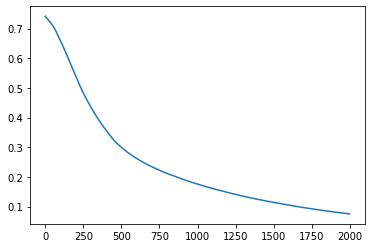

In [ ]:
plt.plot(epochs_losses)

In [ ]:
model(X_train[:1])

tensor([[0.0058]], grad_fn=<SigmoidBackward0>)

In [ ]:
list(model.children())

[Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=1, out_features=1, bias=True),
 Sigmoid()]

In [ ]:
(cnn_w, cnn_b), (lin_w, lin_b) = [(layer.weight.data, \
              layer.bias.data) for layer in \
              list(model.children()) \
              if hasattr(layer,'weight')]

In [ ]:
(cnn_w, cnn_b), (lin_w, lin_b) 

((tensor([[[[0.5347, 0.0478, 1.4283],
            [1.0120, 0.8178, 0.3288],
            [0.9623, 1.2024, 0.8238]]]]), tensor([-0.1766])),
 (tensor([[-1.6376]]), tensor([1.8576])))

In [ ]:
h_im, w_im = X_train.shape[2:]
h_conv, w_conv = cnn_w.shape[2:]
sumprod = torch.zeros((h_im - h_conv + 1, w_im - w_conv + 1))

for i in range(h_im - h_conv + 1):
  for j in range(w_im - w_conv + 1):
    img_subset = X_train[0, 0, i:(i+3), j:(j+3)]
    model_filter = cnn_w.reshape(3,3)
    val = torch.sum(img_subset*model_filter) + cnn_b
    sumprod[i,j] = val
sumprod

tensor([[3.3860, 4.2807],
        [3.2059, 4.2209]])

In [ ]:
relu_layer_output = sumprod.clamp_min_(0)
relu_layer_output

tensor([[3.3860, 4.2807],
        [3.2059, 4.2209]])

In [ ]:
pooling_layer_output = torch.max(sumprod)
pooling_layer_output

tensor(4.2807)

In [ ]:
intermediate_output_value = pooling_layer_output*lin_w+lin_b
intermediate_output_value

tensor([[-5.1526]])

In [ ]:
# Last layer output
print(torch.sigmoid(intermediate_output_value))

tensor([[0.0058]])


##Deep CNN

###Load FashionMNIST training data

In [6]:
data_folder = '~/data/FMNIST' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

val_fmnist=datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

print("Trainig Data Shape",tr_images.size())
print("Trainig Labels Shape",tr_targets.size())
print("Validation Data Shape",val_images.size())
print("Validation Labels Shape",val_targets.size())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw

Trainig Data Shape torch.Size([60000, 28, 28])
Trainig Labels Shape torch.Size([60000])
Validation Data Shape torch.Size([10000, 28, 28])
Validation Labels Shape torch.Size([10000])


###Build Data Loader class

In [ ]:
class FMNISTDataset(Dataset):
  def __init__(self, x, y):
    x = x.float()/255
    x = x.view(-1,1,28,28)
    self.x, self.y = x, y
  def __getitem__(self, ix):
    x, y = self.x[ix], self.y[ix]
    return x.to(device), y.to(device)
  def __len__(self):
    return len(self.x)

###Build Deep CNN Model

In [7]:
def get_model():
  model = nn.Sequential(
          nn.Conv2d(1, 64, kernel_size=3),
          nn.MaxPool2d(2),
          nn.ReLU(),
          nn.Conv2d(64, 128, kernel_size=3),
          nn.MaxPool2d(2),
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(3200, 256),
          nn.ReLU(),
          nn.Linear(256, 10)
          ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer

In [8]:
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

###Data loader function

In [ ]:
def get_data():
  train = FMNISTDataset(tr_images, tr_targets)
  trn_dl = DataLoader(train, batch_size=1000, shuffle=True)
  return trn_dl

###Build Accuracy function

In [9]:
@torch.no_grad()
def accuracy(x, y, model):
  model.eval() # <- let's wait till we get to dropout
  # section
  # get the prediction matrix for a tensor of `x` images
  prediction = model(x)
  # compute if the location of maximum in each row
  # coincides with ground truth
  max_values, argmaxes = prediction.max(-1)
  is_correct = argmaxes == y
  return is_correct.cpu().numpy().tolist()

###Train for 5 epochs

In [ ]:
trn_dl = get_data()
losses, accuracies = [], []
for epoch in range(5):
  epoch_losses, epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    epoch_losses.append(batch_loss)

    is_correct = accuracy(x, y, model)
    epoch_accuracies.extend(is_correct)
  epoch_loss = np.array(epoch_losses).mean()
    
  epoch_accuracy = np.mean(epoch_accuracies)
  losses.append(epoch_loss)
  accuracies.append(epoch_accuracy)

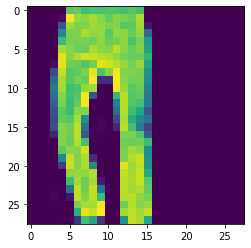

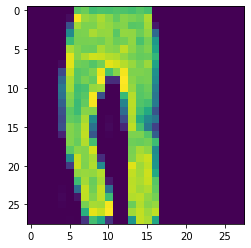

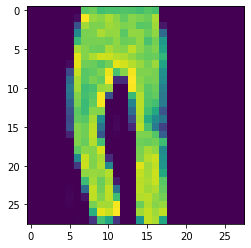

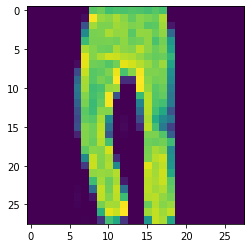

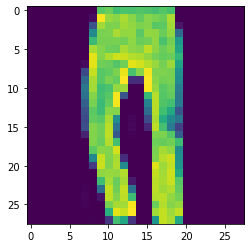

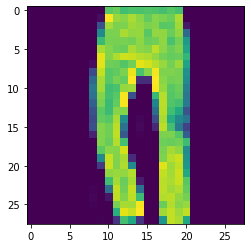

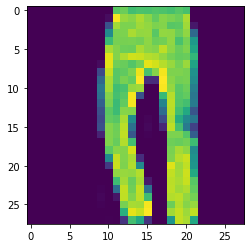

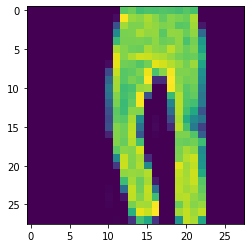

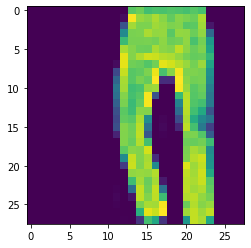

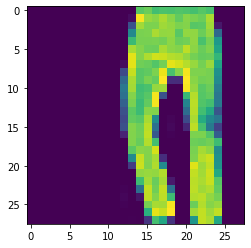

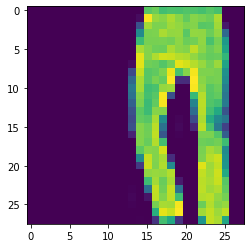

In [ ]:
preds = []
ix = 24300
for px in range(-5,6):
  img = tr_images[ix]/255.
  img = img.view(28, 28)
  img2 = np.roll(img, px, axis=1)
  plt.imshow(img2)
  plt.show()
  img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
  np_output = model(img3).cpu().detach().numpy()
  preds.append(np.exp(np_output)/np.sum(np.exp(np_output)))

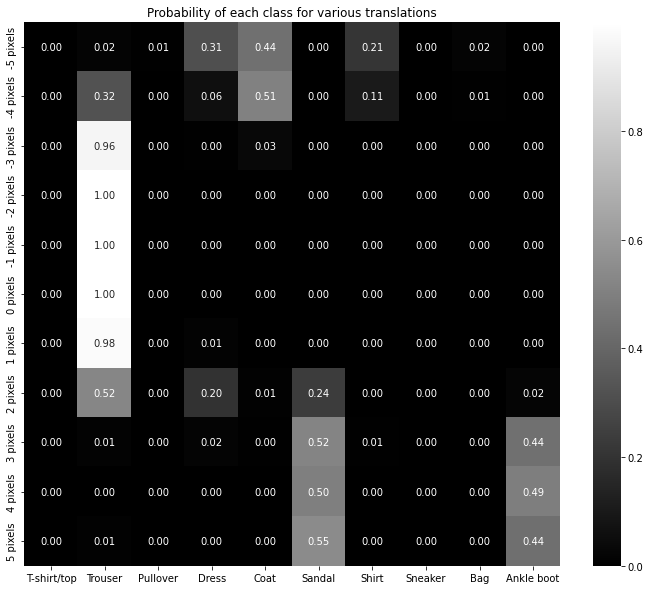

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot=True, \
ax=ax, fmt='.2f', xticklabels=fmnist.classes, \
yticklabels=[str(i)+str(' pixels') \
for i in range(-5,6)], cmap='gray')

##Data augmentation

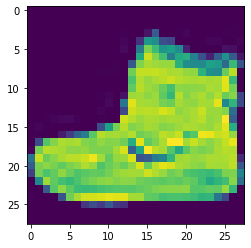

In [ ]:
plt.imshow(tr_images[0])

Text(0.5, 1.0, 'Scaled image')

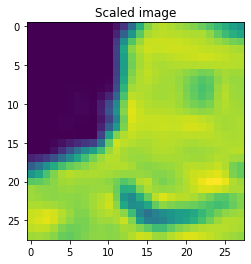

In [12]:
from imgaug import augmenters as iaa
aug = iaa.Affine(scale=2)
plt.imshow(aug.augment_image(tr_images[0].detach().numpy().astype('float32')))
plt.title('Scaled image')

Text(0.5, 1.0, 'Translated image by 10 pixels')

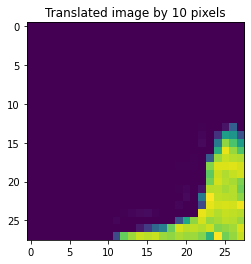

In [ ]:
aug = iaa.Affine(translate_px=10)
plt.imshow(aug.augment_image(tr_images[0].detach().numpy().astype('float32')))
plt.title('Translated image by 10 pixels')

Text(0.5, 1.0, 'Translation of 10 pixels \nacross columns and 2 pixels over rows')

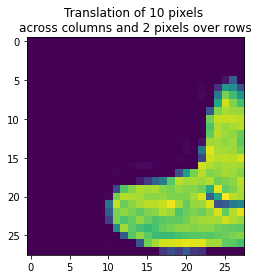

In [ ]:
aug = iaa.Affine(translate_px={'x':10,'y':2})
plt.imshow(aug.augment_image(tr_images[0].detach().numpy().astype('float32')))
plt.title('Translation of 10 pixels \nacross columns and 2 pixels over rows')



*   constant: Pads with a constant value.
*   edge: Pads with the edge values of the array.
*   symmetric: Pads with the reflection of the vector mirrored along the edge  of the array.
*   reflect: Pads with the reflection of the vector mirrored on the first and
last values of the vector along each axis.
*   wrap: Pads with the wrap of the vector along the axis.

###Sequnce of operation

Text(0.5, 1.0, 'Image augmented using a \nrandom order of the two augmentations')

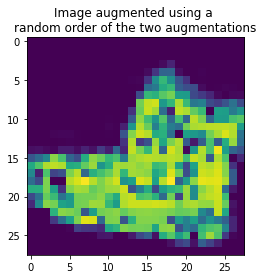

In [ ]:
seq = iaa.Sequential([
              iaa.Dropout(p=0.2),
              iaa.Affine(rotate=(-30,30))],
              random_order= True)
plt.imshow(seq.augment_image(tr_images[0].detach().numpy().astype('float32')))
plt.title('Image augmented using a \nrandom order of the two augmentations')

###Redefine Data Loader class with augmentation

In [10]:
class FMNISTDataset(Dataset):
  def __init__(self, x, y, aug=None):
    self.x, self.y = x, y
    self.aug = aug
  def __getitem__(self, ix):
    x, y = self.x[ix], self.y[ix]
    return x, y
  def __len__(self): 
    return len(self.x)
  def collate_fn(self, batch):
    ims, classes = list(zip(*batch))
    if self.aug: 
      ims=self.aug.augment_images(images=ims)
      ims = torch.tensor(ims)[:,None,:,:].to(device)/255.
      classes = torch.tensor(classes).to(device)
      return ims, classes

In [13]:
aug = iaa.Sequential([
        iaa.Affine(translate_px={'x':(-10,10)},
        mode='constant'),
        ])
def get_data():
  train = FMNISTDataset(tr_images, tr_targets, aug=aug)
  trn_dl = DataLoader(train, batch_size=64, collate_fn=train.collate_fn, shuffle=True)
  val = FMNISTDataset(val_images, val_targets)
  val_dl = DataLoader(val, batch_size=len(val_images),
  collate_fn=val.collate_fn, shuffle=True)
  return trn_dl, val_dl

In [15]:
# #AttributeError: 'Tensor' object has no attribute 'deepcopy'
# trn_dl, val_dl = get_data()
# losses, accuracies = [], []
# for epoch in range(1):
#   epoch_losses, epoch_accuracies = [], []
#   for ix, batch in enumerate(iter(trn_dl)):
#     x, y = batch
#     batch_loss = train_batch(x, y, model, optimizer, loss_fn)
#     epoch_losses.append(batch_loss)

#     is_correct = accuracy(x, y, model)
#     epoch_accuracies.extend(is_correct)
#   epoch_loss = np.array(epoch_losses).mean()
    
#   epoch_accuracy = np.mean(epoch_accuracies)
#   losses.append(epoch_loss)
#   accuracies.append(epoch_accuracy)

##Visualizing the outcome of feature learning

###Download the dataset

In [16]:
!wget https://www.dropbox.com/s/5jh4hpuk2gcxaaq/all.zip
!unzip all.zip

--2022-12-21 12:39:28--  https://www.dropbox.com/s/5jh4hpuk2gcxaaq/all.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/5jh4hpuk2gcxaaq/all.zip [following]
--2022-12-21 12:39:28--  https://www.dropbox.com/s/raw/5jh4hpuk2gcxaaq/all.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5e2b107a60eea0d2529b66d805.dl.dropboxusercontent.com/cd/0/inline/BzCjD6riTPh6zoJKyyZBq6fwIHQd_6zuVKpOuSva1nensakkigp9IYwJk4RLsEWk_6IU6jhousXRCqjGcfdo9SOMB6eLHtZ65Y-FcLnTA7x15YACQS5RZus8TUNLm_1xxcm4XTIjTCMIjd_uHdHm4eqBjDWe0Orx_F1El3B7gavlDQ/file# [following]
--2022-12-21 12:39:28--  https://uc5e2b107a60eea0d2529b66d805.dl.dropboxusercontent.com/cd/0/inline/BzCjD6riTPh6zoJKyyZBq6fwIHQd_6zuVKpOuSva1nensakkigp9IYwJk4RLsEWk_6IU6jhousXRCqjGcfdo9SOMB6eLHtZ

In [17]:
from glob import glob
import cv2
tfm = iaa.Sequential(iaa.Resize(28))
class XO(Dataset):
  def __init__(self, folder):
    self.files = glob(folder)
  def __len__(self):
    return len(self.files)

  def __getitem__(self, ix):
    f = self.files[ix]
    im = tfm.augment_image(cv2.imread(f)[:,:,0])
    im = im[None]
    cl = f.split('/')[-1].split('@')[0] == 'x'
    return torch.tensor(1 - im/255).to(device).float(), \
           torch.tensor([cl]).float().to(device)

In [18]:
data = XO('/content/all/*')

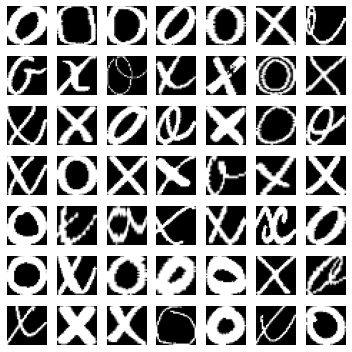

In [20]:
R, C = 7,7
fig, ax = plt.subplots(R, C, figsize=(5,5))
for label_class, plot_row in enumerate(ax):
  for plot_cell in plot_row:
    plot_cell.grid(False); plot_cell.axis('off')
    ix = np.random.choice(1000)
    im, label = data[ix]
    print()
    plot_cell.imshow(im[0].cpu(), cmap='gray')
plt.tight_layout()

In [23]:
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction = model(x)
  is_correct = (prediction > 0.5) == y
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item(), is_correct[0]

In [26]:
def get_model():
  model = nn.Sequential(
  nn.Conv2d(1, 64, kernel_size=3),
  nn.MaxPool2d(2),
  nn.ReLU(),
  nn.Conv2d(64, 128, kernel_size=3),
  nn.MaxPool2d(2),
  nn.ReLU(),
  nn.Flatten(),
  nn.Linear(3200, 256),
  nn.ReLU(),
  nn.Linear(256, 1),
  nn.Sigmoid()
  ).to(device)
  loss_fn = nn.BCELoss()
  optimizer = Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer

In [27]:
trn_dl = DataLoader(XO('/content/all/*'), batch_size=32, drop_last=True)

In [28]:
model, loss_fn, optimizer = get_model()
for epoch in range(5):
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)

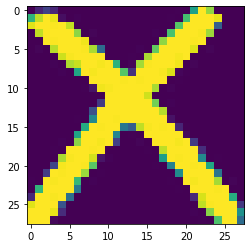

In [29]:
im, c = trn_dl.dataset[2]
plt.imshow(im[0].cpu())
plt.show()

###First Layer outputs for 64 filters

In [30]:
first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im[None])[0].detach()

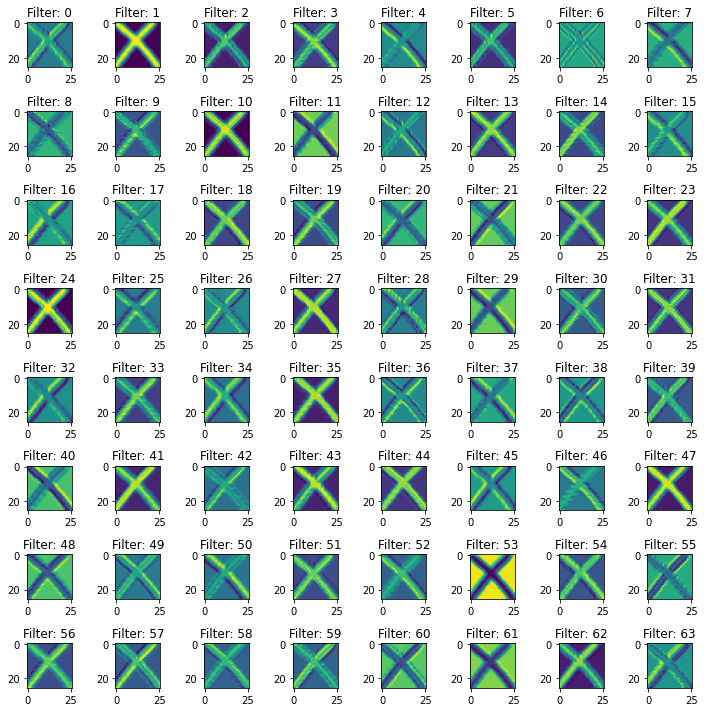

In [32]:
fig, ax = plt.subplots(8, 8, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
  axis.set_title('Filter: '+str(ix))
  axis.imshow(intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()

###First layer outputs for different images

####This is the output of fourth filter

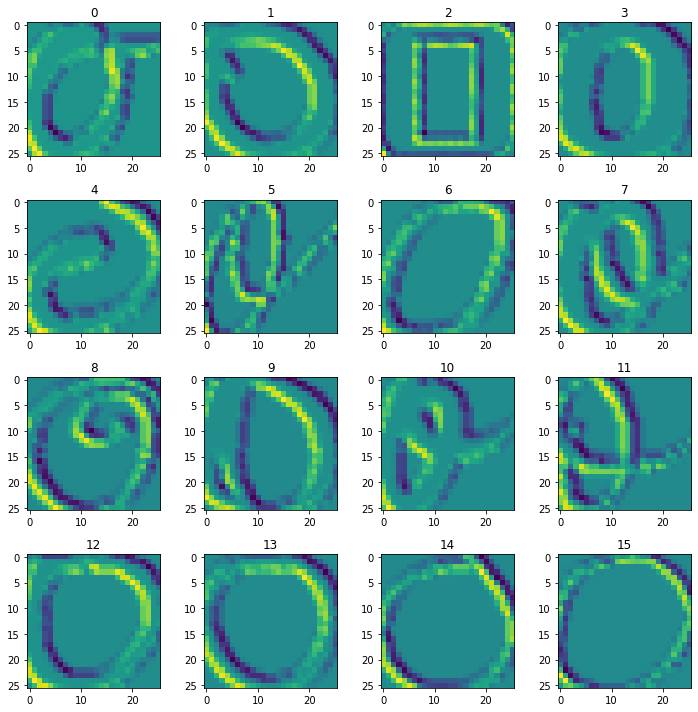

In [33]:
x, y = next(iter(trn_dl))
x2 = x[y==0]
x2 = x2.view(-1,1,28,28)
first_layer = nn.Sequential(*list(model.children())[:1])
first_layer_output = first_layer(x2).detach()
n = 4
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
  axis.imshow(first_layer_output[ix,4,:,:].cpu())
  axis.set_title(str(ix))
plt.tight_layout()
plt.show()

###Second Layer outputs for 121 filters

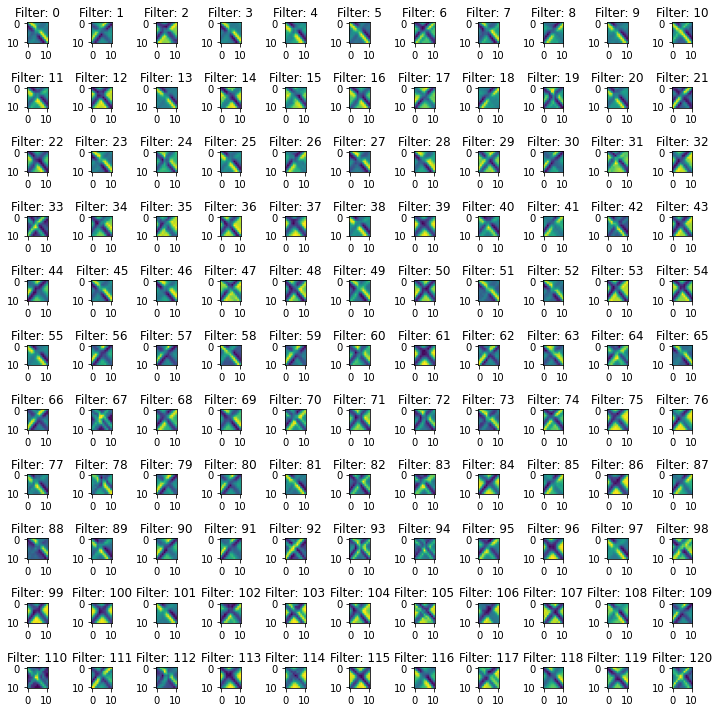

In [37]:
second_layer = nn.Sequential(*list(model.children())[:4])
second_intermediate_output = second_layer(im[None])[0].detach()

fig, ax = plt.subplots(11, 11, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
  axis.set_title('Filter: '+str(ix))
  axis.imshow(second_intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()

###Second Layer ouputs for different images

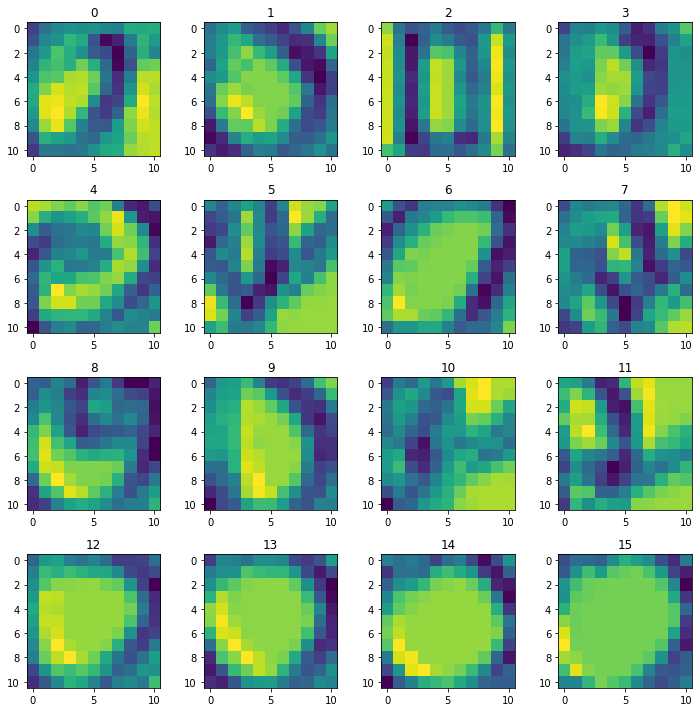

In [38]:
second_intermediate_output = second_layer(x2).detach()
fig, ax = plt.subplots(4, 4, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
  axis.imshow(second_intermediate_output[ix,34,:,:].cpu())
  axis.set_title(str(ix))
plt.tight_layout()
plt.show()